In [1]:
import functools
import os
# os.chdir('/home/mbortkie/repos/crl_subgoal')
import wandb

from rb import TrajectoryUniformSamplingQueue, jit_wrap, segment_ids_per_row
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from agents import agents
from agents.crl import CRLAgent, get_config
from config import ROOT_DIR
from block_moving_env import *

In [2]:
# vmap environment
NUM_ENVS = 256
MAX_REPLAY_SIZE = 10000
BATCH_SIZE = 256
EPISODE_LENGTH = 100
NUM_ACTIONS = 6
SEED = 2


In [3]:
 
env = BoxPushingEnv(grid_size=5, max_steps=200, number_of_boxes=5)
env = AutoResetWrapper(env)
key = random.PRNGKey(2)
keys = random.split(key, NUM_ENVS)
new_state, info = jax.vmap(env.reset)(keys)
print(new_state.grid.shape)
print(info)
# vmap step for 5 consecutive steps using jax.lax.scan
def step_fn(carry, step_num):
    state = carry
    actions = jnp.array([3] * NUM_ENVS)
    new_state, reward, done, info = jax.vmap(env.step)(state, actions)
    timestep = TimeStep(
        key=state.key,
        grid=state.grid,
        target_cells=state.target_cells,
        agent_pos=state.agent_pos,
        agent_has_box=state.agent_has_box,
        steps=state.steps,
        action=actions, 
        goal=state.goal,
        reward=reward
    )
    # return new_state, (new_state, reward, done, info)
    return new_state, (new_state, timestep)


(256, 5, 5)
{'boxes_on_target': Array([2, 2, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 3, 2, 0, 1, 2, 2, 1, 3, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 2, 0, 1, 0, 1, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 3, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1,
       0, 2, 2, 1, 1, 1, 2, 3, 1, 2, 1, 2, 0, 1, 0, 2, 0, 2, 1, 0, 0, 1,
       3, 0, 0, 1, 0, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 2, 1, 1,
       1, 0, 3, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 3, 2, 1, 1, 2, 1, 1, 0, 0, 1, 1, 3, 0, 0, 2, 3,
       0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 2, 0,
       0, 2, 1, 2, 1, 3, 3, 0, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 2, 0, 0, 0, 2, 1, 2, 0, 0, 2], dtype=int32)}


In [4]:

# final_state, (states, rewards, dones, infos) = jax.lax.scan(
final_state, (states, timesteps) = jax.lax.scan(
    step_fn, 
    new_state, 
    jnp.arange(EPISODE_LENGTH)
)
new_state = final_state

timestep = jax.tree_util.tree_map(lambda x: x[0, 0], timesteps)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=MAX_REPLAY_SIZE,
        dummy_data_sample=timestep,
        sample_batch_size=BATCH_SIZE,
        num_envs=NUM_ENVS,
        episode_length=EPISODE_LENGTH,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)
buffer_state = replay_buffer.insert(buffer_state, timesteps)
buffer_state, transitions = replay_buffer.sample(buffer_state)


# Agent
config = get_config()
config['discrete'] = True
agent_class = agents[config['agent_name']]



In [5]:
example_batch = {
    'observations':transitions.grid[:,0,:].reshape(transitions.grid.shape[0], transitions.grid.shape[-1]*transitions.grid.shape[-2]),  # Add batch dimension 
    'actions': jnp.ones((transitions.grid.shape[0],), dtype=jnp.int32) * (NUM_ACTIONS-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'value_goals': transitions.grid[:,0,:].reshape(transitions.grid.shape[0], transitions.grid.shape[-1]*transitions.grid.shape[-2]),
    'actor_goals': transitions.grid[:,0,:].reshape(transitions.grid.shape[0], transitions.grid.shape[-1]*transitions.grid.shape[-2]),
}

print("Testing agent creation")
agent = agent_class.create(
    SEED,
    example_batch['observations'],
    example_batch['actions'],
    config,
    example_batch['value_goals'],
)
print("Agent created")

agent, update_info = agent.update(example_batch)
print(update_info)


Testing agent creation


2025-06-24 23:51:37.484447: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Agent created


2025-06-24 23:51:42.969289: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-24 23:51:42.969588: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-24 23:51:42.969625: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-24 23:51:42.969813: W external/xla/xla/service/gpu/au

{'actor/actor_loss': Array(1.6171699, dtype=float32), 'actor/adv': Array(-1.8340467, dtype=float32), 'actor/bc_log_prob': Array(-1.896842, dtype=float32), 'critic/binary_accuracy': Array(0.50805664, dtype=float32), 'critic/categorical_accuracy': Array(0.015625, dtype=float32), 'critic/contrastive_loss': Array(0.9171901, dtype=float32), 'critic/logits': Array(-0.02172719, dtype=float32), 'critic/logits_neg': Array(-0.02307082, dtype=float32), 'critic/logits_pos': Array(0.32089865, dtype=float32), 'critic/v_max': Array(125.71013, dtype=float32), 'critic/v_mean': Array(4.0378513, dtype=float32), 'critic/v_min': Array(0.01116146, dtype=float32), 'grad/max': Array(0.6339097, dtype=float32), 'grad/min': Array(-1.0111623, dtype=float32), 'grad/norm': Array(68.05155, dtype=float32), 'value/binary_accuracy': Array(0.23318481, dtype=float32), 'value/categorical_accuracy': Array(0.00390625, dtype=float32), 'value/contrastive_loss': Array(1.603905, dtype=float32), 'value/logits': Array(1.1254321, 

In [6]:
def collect_data(agent, key):
        env = BoxPushingEnv(grid_size=5, max_steps=200, number_of_boxes=5)
        env = AutoResetWrapper(env)
        
        def step_fn(carry, step_num):
            state, info, key = carry
            key, new_key = jax.random.split(key)
            print(f"state.grid.shape: {state.grid.shape}", flush=True)
            actions = agent.sample_actions(state.grid.reshape(NUM_ENVS, -1), state.goal.reshape(NUM_ENVS, -1), seed=key)
            new_state, reward, done, info = jax.vmap(env.step)(state, actions)
            timestep = TimeStep(
                key=state.key,
                grid=state.grid,
                target_cells=state.target_cells,
                agent_pos=state.agent_pos,
                agent_has_box=state.agent_has_box,
                steps=state.steps,
                action=actions,
                goal=state.goal,
                reward=reward
            )
            return (new_state, info, new_key), timestep
        
        keys = jax.random.split(key, NUM_ENVS)
        state, info = jax.vmap(env.reset)(keys)
        (timestep, info, key), timesteps_all = jax.lax.scan(step_fn, (state, info, key), (), length=EPISODE_LENGTH)
        return timestep, info, timesteps_all

In [21]:
env_step, info, timesteps_all = collect_data(agent, key)

# Visualize the states
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=MAX_REPLAY_SIZE,
        dummy_data_sample=timestep,
        sample_batch_size=BATCH_SIZE,
        num_envs=NUM_ENVS,
        episode_length=EPISODE_LENGTH,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

buffer_state = replay_buffer.insert(buffer_state, timesteps_all)

buffer_state, transitions = replay_buffer.sample(buffer_state)
batch_keys = jax.random.split(buffer_state.key, transitions.grid.shape[0])
state, future_state, goal_index = jax.vmap(flatten_batch, in_axes=(None, 0, 0))((0.99, None, None), transitions, batch_keys)
print(state.grid.shape)
print(future_state.grid.shape)
print(goal_index.shape)

state.grid.shape: (256, 5, 5)
(256, 99, 5, 5)
(256, 99, 5, 5)
(256, 100)


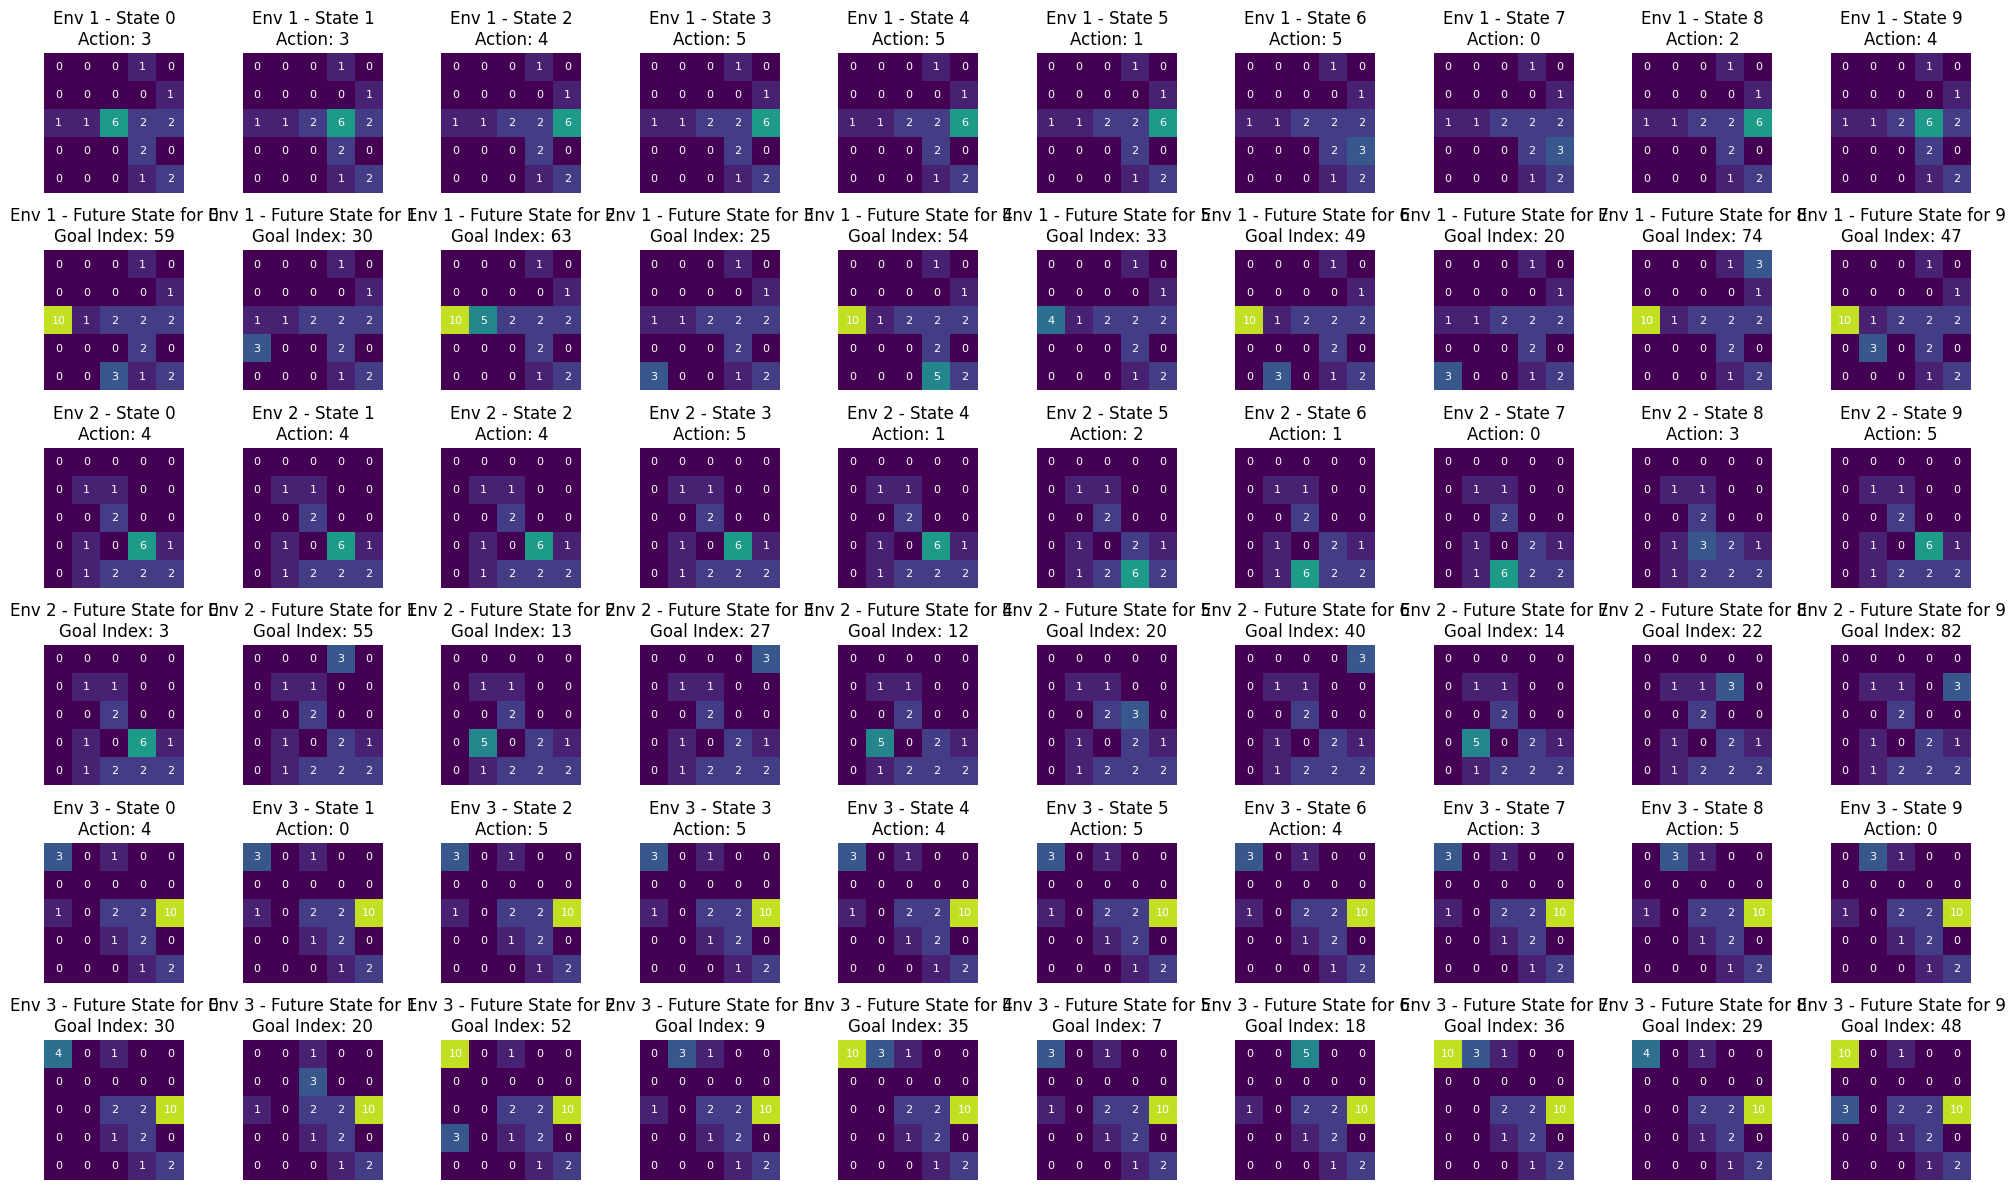

In [ ]:

# Create a figure with subplots for each timestep
import matplotlib.pyplot as plt

def plot_env_states(axes, state, future_state, goal_index, env_idx, timestep_idx):
    """Helper function to plot states for a single environment"""
    display_state = jax.tree_util.tree_map(lambda x: x[env_idx, timestep_idx], state)
    display_future_state = jax.tree_util.tree_map(lambda x: x[env_idx, timestep_idx], future_state)
    
    # Plot current state with consistent color mapping
    im1 = axes[0].imshow(display_state.grid, vmin=0, vmax=11)
    axes[0].set_title(f'Env {env_idx + 1} - State {timestep_idx}\nAction: {state.action[env_idx, timestep_idx]}')
    axes[0].axis('off')
    
    # Add text annotations for current state
    for row in range(display_state.grid.shape[0]):
        for col in range(display_state.grid.shape[1]):
            axes[0].text(col, row, int(display_state.grid[row, col]),
                        ha="center", va="center", color="white", fontsize=8)
    
    # Plot future state with consistent color mapping
    im2 = axes[1].imshow(display_future_state.grid, vmin=0, vmax=11)
    axes[1].set_title(f'Env {env_idx + 1} - Future State for {timestep_idx}\nGoal Index: {goal_index[env_idx, timestep_idx]}')
    axes[1].axis('off')
    
    # Add text annotations for future state
    for row in range(display_future_state.grid.shape[0]):
        for col in range(display_future_state.grid.shape[1]):
            axes[1].text(col, row, int(display_future_state.grid[row, col]),
                        ha="center", va="center", color="white", fontsize=8)

# Create figure with 6 rows (2 for each of 3 envs) and 10 columns
fig, axes = plt.subplots(6, 10, figsize=(20, 12))

# Plot for each timestep
for i in range(10):
    # Plot for each environment
    for env_idx in range(3):
        row_start = env_idx * 2
        plot_env_states(axes[row_start:row_start+2, i], state, future_state, goal_index, env_idx, i)

plt.tight_layout()
# plt.savefig(ROOT_DIR + "/block_moving_states_comparison.png")
plt.show()


In [9]:
buffer_state, transitions = replay_buffer.sample(buffer_state)
batch_keys = jax.random.split(buffer_state.key, transitions.grid.shape[0])
state, future_state, goal_index = jax.vmap(flatten_batch, in_axes=(None, 0, 0))((0.99, None, None), transitions, batch_keys)

state.grid.shape

(256, 99, 5, 5)

In [10]:
# Take different time indices for each environment
key, subkey = jax.random.split(key)
random_indices = jax.random.randint(subkey, (state.grid.shape[0],), minval=0, maxval=state.grid.shape[1])

# Extract data at random indices for each environment
state = jax.tree_util.tree_map(lambda x: x[jnp.arange(x.shape[0]), random_indices], state)
actions = state.action
future_state = jax.tree_util.tree_map(lambda x: x[jnp.arange(x.shape[0]), random_indices], future_state)
goal_index = jax.tree_util.tree_map(lambda x: x[jnp.arange(x.shape[0]), random_indices], goal_index)


In [11]:
print(random_indices.shape)
print(random_indices)

(256,)
[92 12 71 61 75 66 40 13 52 11 62 58  4 34 75 65 77  3 64 82 66 44 11 29
 13  8 92 57 75 70 79 39 60 48 79 51  6 98 15 68 66 79 29 60 37 74 85 40
 29 96 60 27 87 50 64 66 69 88 31 76 95 61 64 11 67 56 34 58 33  8 19 21
 11  8 39 32 17 95 27 39  8 97 48 24 11 29 94 14 61 80 82  0 33 25 92 86
 31 22  4  0 40 70 17 90 27  8 88 53 53 12 14 66 61 27 82 77 52 31 23  8
 16  6 90 96  1 61 97 87 39 47 16  0  7  3 97 55 90 32 42 38 94 70 11 70
 51 48 33 67 90 40 24 50 29 23 25 22 75 61 45 53  6 98 51 80 11 13 57 79
 88  5 19  5 54 42 38 41 68 73 28 51 90 57 80  4 32 59 79 68  8 72 83 68
 77 29 73 54 34 85 15 44 24 90 14 98 84 26 95 18 78 58 18 43 82 32  9 83
 40 72 66 50 56 48 74 69 47 84 40 84 71 30 18  6 55 30 53 85 90 33 92 14
 40 97 60 74 91 76 94 59 25 93 89  6 54 46 86  9]


In [12]:
state.grid.shape

(256, 5, 5)

In [13]:

# Minimal example of advanced indexing with 2D arrays
import jax.numpy as jnp

# Create a simple 2D array
arr = jnp.array([[1, 2, 3, 4, 5],
                 [6, 7, 8, 9, 10],
                 [11, 12, 13, 14, 15]])

print("Original array:")
print(arr)
print(f"Shape: {arr.shape}")  # (3, 5)

# Create random indices for each row
indices = jnp.array([2, 0, 4])  # Select index 2 from row 0, index 0 from row 1, index 4 from row 2

print(f"\nIndices: {indices}")

# Method 1: Using advanced indexing
result1 = arr[jnp.arange(arr.shape[0]), indices]
print(f"\nResult using advanced indexing: {result1}")  # [3, 6, 15]

# Method 2: Using tree_map (like in your code)
result2 = jax.tree_util.tree_map(lambda x: x[jnp.arange(x.shape[0]), indices], arr)
print(f"Result using tree_map: {result2}")  # [3, 6, 15]


Original array:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]]
Shape: (3, 5)

Indices: [2 0 4]



Result using advanced indexing: [ 3  6 15]
Result using tree_map: [ 3  6 15]


In [14]:
# Display first state and goal from env 0
print("First state from env 0:")
print(state.grid[0])  # First environment's state

print("\nFirst goal from env 0:")
print(future_state.grid[0])  # First environment's goal

First state from env 0:
[[ 1  0  0  0  0]
 [ 1  0  0  0  0]
 [10  0  2  3 10]
 [ 0  0  0  2  2]
 [ 0  0  2  1  0]]

First goal from env 0:
[[ 1  0  0  0  0]
 [ 1  0  0  0  0]
 [10  0  2  0 10]
 [ 0  0  3  2  2]
 [ 0  0  2  1  0]]


In [20]:
dist = agent.network.select('actor')(example_batch['observations'], example_batch['actor_goals'], params=None)
print(f"dist: {dist}")
log_prob = dist.log_prob(example_batch['actions'])
print(f"log_prob: {log_prob}")
print(f"log_prob.shape: {log_prob.shape}")

dist: <distrax._src.distributions.categorical.Categorical object at 0x7f6b805c51d0>
log_prob: [-1.7707723 -1.9044468 -1.8880867 -1.8105048 -1.8417469 -1.7363682
 -1.7564802 -1.8501613 -1.9473417 -1.9229048 -1.8372777 -1.829298
 -1.9202762 -1.8219049 -1.8904512 -1.7764177 -1.952714  -1.8346503
 -1.8377479 -1.8812158 -1.7248347 -1.9308357 -1.8559458 -1.8288224
 -1.7715064 -1.7299178 -1.7807621 -1.8715861 -1.9954005 -1.810406
 -1.8546978 -1.7729146 -1.8093443 -1.8995992 -1.8094968 -1.856905
 -1.8205254 -1.7794926 -1.7625531 -1.7694461 -1.8140782 -1.8583081
 -1.8538698 -1.823663  -1.812856  -1.8612099 -1.965806  -1.9419127
 -1.8598553 -1.8407611 -1.8753841 -1.7731978 -1.800508  -1.8386815
 -1.7812084 -1.8582244 -1.7560507 -1.8044782 -1.7532763 -1.7811646
 -1.8278794 -1.8723909 -1.798603  -1.7850292 -1.8296219 -1.8438251
 -1.8337519 -1.8696666 -1.7891217 -1.8425003 -1.8447877 -1.8602011
 -1.8175848 -1.8198655 -1.8522121 -1.8049457 -1.7886571 -1.842685
 -1.827725  -1.7458425 -1.7463877 -1.76